# Realistic example using outputs from MITgcm
This example requires the understanding of [xgcm.grid](https://xgcm.readthedocs.io/en/latest/api.html#grid) and [xmitgcm.open_mdsdataset](https://xmitgcm.readthedocs.io/en/latest/usage.html).

In [1]:
import numpy as np
import xarray as xr
import os.path as op
import xrft
from dask.diagnostics import ProgressBar
from xmitgcm import open_mdsdataset
from xgcm.grid import Grid
from matplotlib import colors, ticker
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ddir = '/swot/SUM05/takaya/MITgcm/channel/runs/'

One year of daily-averaged output from MITgcm.

In [3]:
ys20, dy20 = (60,1)
dt = 8e2
df = 108
ts = int(360*86400*ys20/dt+df)
te = int(360*86400*(ys20+dy20)/dt+df)
ds = open_mdsdataset(op.join(ddir,'zerores_20km_MOMbgc'), grid_dir=op.join(ddir,'20km_grid'),
                    iters=range(ts,te,df), prefix=['MOMtave'], delta_t=dt
                    ).sel(YC=slice(5e5,15e5), YG=slice(5e5,15e5))
ds

/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (XC: 50, XG: 50, YC: 50, YG: 51, Z: 40, Zl: 40, Zp1: 41, Zu: 40, time: 360)
Coordinates:
  * XC       (XC) >f4 10000.0 30000.0 50000.0 70000.0 90000.0 110000.0 ...
  * YC       (YC) >f4 510000.0 530000.0 550000.0 570000.0 590000.0 610000.0 ...
  * XG       (XG) >f4 0.0 20000.0 40000.0 60000.0 80000.0 100000.0 120000.0 ...
  * YG       (YG) >f4 500000.0 520000.0 540000.0 560000.0 580000.0 600000.0 ...
  * Z        (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 -126.0 ...
  * Zp1      (Zp1) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * Zu       (Zu) >f4 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * Zl       (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
    rA       (YC, XC) >f4 dask.array<shape=(50, 50), chunksize=(50, 50)>
    dxG      (YG, XC) >f4 dask.array<shape=(51, 50), chunksize=(51, 50)>
    dyG      (YC, XG) >f4 dask.array<shape=(50, 50), chunksize=(50, 50)>
    Depth    (YC, XC) >f4 dask.ar

In [4]:
grid = Grid(ds, periodic=['X'])

In [5]:
u = ds.UVEL     #zonal velocity
v = ds.VVEL     #meridional velocity
w = ds.WVEL     #vertical velocity
phi = ds.PHIHYD #hydrostatic pressure

## Discrete Fourier Transform

We chunk the data along the `time` and `Z` axes to allow parallelized computation and detrend and window the data before taking the DFT along the horizontal axes.

In [6]:
b = grid.diff(phi,'Z',boundary='fill')/grid.diff(phi.Z,'Z',boundary='fill')
with ProgressBar():
    what = xrft.dft(w.chunk({'time':1,'Zl':1}), 
                    dim=['XC','YC'], detrend='linear', window=True).compute()
    bhat = xrft.dft(b.chunk({'time':1,'Zl':1}), 
                    dim=['XC','YC'], detrend='linear', window=True).compute()
bhat

/home/takaya/xrft/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


[########################################] | 100% Completed |  3min 18.9s
[########################################] | 100% Completed |  3min 20.1s


<xarray.DataArray 'rechunk-merge-20d2920474ad47b75b05955c0456f69d' (time: 360, Zl: 40, freq_YC: 50, freq_XC: 50)>
array([[[[ 2.801601e-03+8.771196e-17j, ..., -1.076925e-03-1.451031e-03j],
         ...,
         [-6.912831e-04-1.127047e-03j, ..., -1.114039e-03+8.825552e-04j]],

        ...,

        [[ 3.786092e-07-9.317362e-21j, ..., -7.612376e-07-3.355050e-07j],
         ...,
         [ 1.314610e-06+7.461259e-07j, ..., -1.471702e-06-5.475275e-07j]]],


       ...,


       [[[-3.941056e-04-1.888680e-16j, ..., -6.151166e-04+1.212955e-03j],
         ...,
         [-3.724654e-04+6.164418e-04j, ...,  1.445227e-03-2.389259e-04j]],

        ...,

        [[ 3.398755e-07-5.251604e-20j, ..., -7.561893e-07-1.006210e-06j],
         ...,
         [ 3.863488e-07+5.592156e-07j, ...,  1.252672e-06+1.153922e-06j]]]])
Coordinates:
  * time             (time) float64 1.866e+09 1.866e+09 1.866e+09 1.867e+09 ...
  * Zl               (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 ...
  * freq_YC 

## Power spectrum

We compute the surface eddy kinetic energy spectrum.

In [8]:
with ProgressBar():
    uhat2 = xrft.power_spectrum(grid.interp(u,'X')[:,0].chunk({'time':1}), 
                             dim=['XC','YC'], detrend='linear', window=True).compute()
    vhat2 = xrft.power_spectrum(grid.interp(v,'Y',boundary='fill')[:,0].chunk({'time':1}), 
                             dim=['XC','YC'], detrend='linear', window=True).compute()
ekehat = .5*(uhat2 + vhat2)
ekehat

/home/takaya/xrft/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


[########################################] | 100% Completed |  6.7s
[########################################] | 100% Completed |  6.4s


<xarray.DataArray (time: 360, freq_YC: 50, freq_XC: 50)>
array([[[0.656013, 0.634131, ..., 0.373603, 0.634131],
        [0.420887, 0.593453, ..., 1.585473, 1.477422],
        ...,
        [1.743543, 0.468147, ..., 2.274391, 3.250841],
        [0.420887, 1.477422, ..., 1.285897, 0.593453]],

       [[0.005765, 0.126508, ..., 0.363493, 0.126508],
        [0.099985, 0.140124, ..., 0.49843 , 0.109594],
        ...,
        [1.436623, 0.598675, ..., 1.692357, 0.797681],
        [0.099985, 0.109594, ..., 0.497809, 0.140124]],

       ...,

       [[0.063022, 0.463507, ..., 0.839914, 0.463507],
        [0.161973, 0.310822, ..., 1.181991, 0.372522],
        ...,
        [0.122832, 0.415118, ..., 0.231018, 0.244315],
        [0.161973, 0.372522, ..., 0.500013, 0.310822]],

       [[0.140999, 0.475876, ..., 1.034042, 0.475876],
        [0.032224, 0.080152, ..., 1.088543, 0.660645],
        ...,
        [0.545666, 0.291697, ..., 4.745674, 1.533154],
        [0.032224, 0.660645, ..., 0.817556, 0.0

## Isotropic wavenumber spectrum

We now isotropize the spectrum:

In [11]:
with ProgressBar():
    uiso2 = xrft.isotropic_powerspectrum(grid.interp(u,'X')[0,0], 
                                         dim=['XC','YC'], detrend='linear', window=True).compute()
    viso2 = xrft.isotropic_powerspectrum(grid.interp(v,'Y',boundary='fill')[0,0], 
                                         dim=['XC','YC'], detrend='linear', window=True).compute()
ekeiso = .5*(uiso2 + viso2)
ekeiso

[########################################] | 100% Completed |  0.1s


/home/takaya/xrft/xrft/xrft.py:428: RuntimeWarning: invalid value encountered in true_divide
  kr = np.bincount(kidx, weights=K.ravel()) / area
/home/takaya/xrft/xrft/xrft.py:433: RuntimeWarning: invalid value encountered in true_divide
  / area) * kr


[########################################] | 100% Completed |  0.1s


<xarray.DataArray (freq_r: 13)>
array([         nan, 6.735224e+01, 1.488857e+02, 4.130706e+01, 1.541406e+01,
       9.217845e+00, 5.425922e+00, 1.887154e+00, 5.665645e-01, 2.813448e-01,
       6.721589e-02, 2.577505e-02, 7.507335e-03])
Coordinates:
  * freq_r   (freq_r) float64 nan 1.358e-06 3.36e-06 5.571e-06 7.73e-06 ...

We plot $u$, $v$, $\hat{u}^2+$

Text(0,0.5,'[m$^3$ s$^{-2}$]')

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


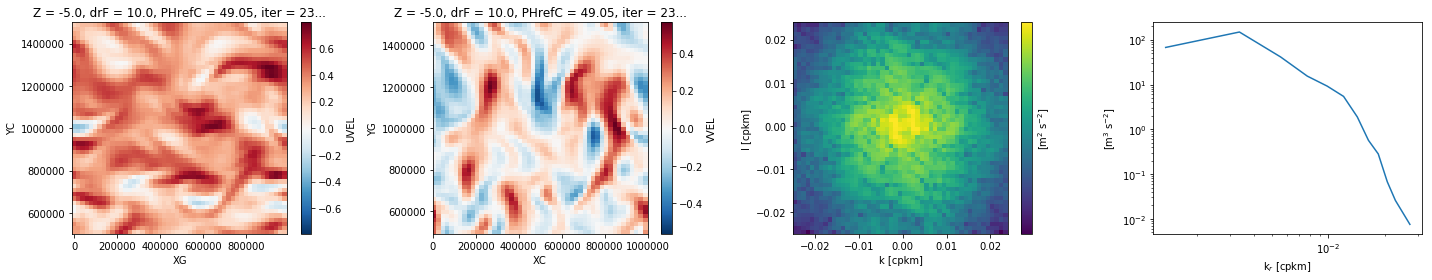

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,4))
fig.set_tight_layout(True)
u[0,0].plot(ax=axes[0])
v[0,0].plot(ax=axes[1])
im = axes[2].pcolormesh(ekehat.freq_XC*1e3, ekehat.freq_YC*1e3, ekehat[0],
                       norm=colors.LogNorm())
axes[3].plot(ekeiso.freq_r*1e3, ekeiso)
cbar = fig.colorbar(im, ax=axes[2])
cbar.set_label(r'[m$^2$ s$^{-2}$]')
axes[3].set_xscale('log')
axes[3].set_yscale('log')
axes[2].set_xlabel(r'k [cpkm]')
axes[2].set_ylabel(r'l [cpkm]')
axes[3].set_xlabel(r'k$_r$ [cpkm]')
axes[3].set_ylabel(r'[m$^3$ s$^{-2}$]')

## Cross Spectrum

We calculate the cross correlation between vertical velocity ($w$) and buoyancy ($b$):

In [31]:
with ProgressBar():
    whatbhat = xrft.cross_spectrum(w.chunk({'time':1,'Zl':1}), b.chunk({'time':1,'Zl':1}), 
                                   dim=['XC','YC'], detrend='linear', window=True, density=False).compute()
whatbhat

/home/takaya/xrft/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


[########################################] | 100% Completed |  7min 48.4s


<xarray.DataArray (time: 360, Zl: 40, freq_YC: 50, freq_XC: 50)>
array([[[[ 6.217574e-11, ...,  5.227157e-11],
         ...,
         [-1.960930e-12, ...,  1.145311e-11]],

        ...,

        [[ 2.433719e-11, ...,  4.670022e-11],
         ...,
         [-9.319683e-11, ..., -7.301667e-11]]],


       ...,


       [[[-8.180808e-12, ...,  1.913746e-11],
         ...,
         [ 4.396894e-12, ..., -1.844566e-12]],

        ...,

        [[-1.291420e-11, ...,  2.346000e-11],
         ...,
         [ 2.565280e-11, ...,  4.489265e-11]]]])
Coordinates:
  * time             (time) float64 1.866e+09 1.866e+09 1.866e+09 1.867e+09 ...
  * Zl               (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 ...
  * freq_YC          (freq_YC) float64 -2.5e-05 -2.4e-05 -2.3e-05 -2.2e-05 ...
  * freq_XC          (freq_XC) float64 -2.5e-05 -2.4e-05 -2.3e-05 -2.2e-05 ...
    freq_XC_spacing  float64 1e-06
    freq_YC_spacing  float64 1e-06

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


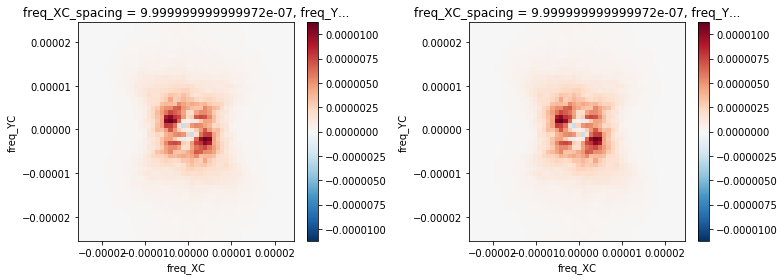

In [32]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,4))
fig.set_tight_layout(True)
(what*np.conjugate(bhat)).real[:,:8].mean(['time','Zl']).plot(ax=ax1)
whatbhat[:,:8].mean(['time','Zl']).plot(ax=ax2)

We see that $\hat{w}\hat{b}^*$ and `xrft.cross_spectrum`$(w,b)$ are equivalent.